In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import warnings
import sys
from glob import glob
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from category_encoders import TargetEncoder

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Define file paths (Update these paths accordingly)
TRAIN_DATA_DIR = './TrainingData'  # Replace with your training data directory path
SUBMISSION_PATH = './submission.csv'           # Replace with your desired submission path

# Define constants
TARGET_COLUMN = 'Power(mW)'  # Replace with your target column name
ID_COLUMN = 'LocationCode'                     # Replace with your ID column name (if available)
N_SPLITS = 5                         # Number of folds for cross-validation
RANDOM_STATE = 42                    # Random seed for reproducibility

# Function to load and concatenate multiple CSV files
def load_and_concatenate_csvs(data_dir):
    """
    Load all CSV files from the specified directory and concatenate them into a single DataFrame.
    
    Parameters:
        data_dir (str): Path to the directory containing CSV files.
    
    Returns:
        pd.DataFrame: Concatenated DataFrame containing all training data.
    """
    all_files = glob(os.path.join(data_dir, "*.csv"))
    if not all_files:
        print(f"No CSV files found in directory: {data_dir}")
        sys.exit(1)
    
    list_df = []
    for file in all_files:
        try:
            df = pd.read_csv(file)
            list_df.append(df)
            print(f"Loaded file: {file} with shape {df.shape}")
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    combined_df = pd.concat(list_df, ignore_index=True)
    print(f"Combined DataFrame shape: {combined_df.shape}")
    return combined_df

# Function to preprocess data
def preprocess_data(df):
    """
    Preprocess the combined DataFrame.
    - Handle missing values
    - Encode categorical variables appropriately
    - Feature scaling
    - Split into training and validation sets
    
    Parameters:
        df (pd.DataFrame): Combined DataFrame containing all training data.
    
    Returns:
        X_train (pd.DataFrame): Preprocessed training features.
        X_val (pd.DataFrame): Preprocessed validation features.
        y_train (pd.Series): Training target.
        y_val (pd.Series): Validation target.
        ids_train (pd.Series): Training IDs (if available).
        ids_val (pd.Series): Validation IDs (if available).
        scaler (StandardScaler): Fitted scaler object.
        encoder (TargetEncoder): Fitted encoder object.
    """
    # Identify if ID_COLUMN exists and separate it
    if ID_COLUMN in df.columns:
        ids = df[ID_COLUMN]
        df = df.drop(columns=[ID_COLUMN])
    else:
        ids = None

    # Separate features and target
    X = df.drop(columns=[TARGET_COLUMN])
    y = df[TARGET_COLUMN]

    # Identify numerical and categorical columns
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

    # Handle missing values
    for col in numerical_cols:
        median = X[col].median()
        X[col].fillna(median, inplace=True)

    for col in categorical_cols:
        mode = X[col].mode()[0]
        X[col].fillna(mode, inplace=True)

    # Identify high and low cardinality categorical columns
    high_cardinality_cols = [col for col in categorical_cols if X[col].nunique() > 100]
    low_cardinality_cols = [col for col in categorical_cols if X[col].nunique() <= 100]

    print(f"High-Cardinality Columns ({len(high_cardinality_cols)}): {high_cardinality_cols}")
    print(f"Low-Cardinality Columns ({len(low_cardinality_cols)}): {low_cardinality_cols}")

    # Handle low-cardinality categorical columns with one-hot encoding
    X_encoded = pd.get_dummies(X, columns=low_cardinality_cols, drop_first=True)
    print(f"Shape after one-hot encoding low-cardinality columns: {X_encoded.shape}")

    # Handle high-cardinality categorical columns with target encoding
    if high_cardinality_cols:
        encoder = TargetEncoder(cols=high_cardinality_cols)
        X_encoded[high_cardinality_cols] = encoder.fit_transform(X_encoded[high_cardinality_cols], y)
        print(f"Applied target encoding on high-cardinality columns.")
    else:
        encoder = None

    # Feature Scaling
    scaler = StandardScaler()
    X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])

    # Optional: Feature Engineering can be added here

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_encoded, y, test_size=0.2, random_state=RANDOM_STATE
    )

    # If IDs were present, split them accordingly
    if ids is not None:
        ids_train, ids_val = train_test_split(
            ids, test_size=0.2, random_state=RANDOM_STATE
        )
    else:
        ids_train, ids_val = None, None

    print(f"Training set shape: {X_train.shape}")
    print(f"Validation set shape: {X_val.shape}")

    return X_train, X_val, y_train, y_val, ids_train, ids_val, scaler, encoder

# Function to define individual models
def define_models():
    """
    Define all individual models to be compared.
    
    Returns:
        dict: Dictionary of model names and their corresponding instances.
    """
    models = {}
    
    # LightGBM Regressor
    models['LightGBM'] = lgb.LGBMRegressor(
        objective='regression',
        num_leaves=31,
        learning_rate=0.05,
        n_estimators=1000,
        random_state=RANDOM_STATE
    )
    
    # XGBoost Regressor
    models['XGBoost'] = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    # CatBoost Regressor
    models['CatBoost'] = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='MAE',
        eval_metric='MAE',
        random_seed=RANDOM_STATE,
        early_stopping_rounds=50,
        verbose=0
    )
    
    # Define a simpler and optimized MLPRegressor
    models['MLPRegressor'] = MLPRegressor(
        hidden_layer_sizes=(64, 32),  # Reduced complexity
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size='auto',
        learning_rate='adaptive',
        max_iter=200,  # Limited iterations
        tol=1e-3,       # Increased tolerance
        early_stopping=True,  # Enable early stopping
        validation_fraction=0.1,
        random_state=RANDOM_STATE,
        verbose=True  # Enable verbose to monitor progress
    )
    
    return models

# Function to define ensemble models
def define_ensemble_models():
    """
    Define Stacking and Voting Ensemble models.
    
    Returns:
        dict: Dictionary of ensemble model names and their corresponding instances.
    """
    # Define base learners
    base_learners = [
        ('lgb', lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=RANDOM_STATE)),
        ('xgb', xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=RANDOM_STATE)),
        ('cat', CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, loss_function='MAE',
                                 eval_metric='MAE', random_seed=RANDOM_STATE, verbose=0))
    ]
    
    # Define Stacking Regressor with Linear Regression as meta-learner
    stacking_regressor = StackingRegressor(
        estimators=base_learners,
        final_estimator=LinearRegression(),
        passthrough=True,
        cv=5,
        n_jobs=-1
    )
    
    # Define Voting Regressor (soft voting via averaging)
    voting_regressor = VotingRegressor(
        estimators=base_learners,
        weights=[1, 1, 1]
    )
    
    ensemble_models = {
        'StackingRegressor': stacking_regressor,
        'VotingRegressor': voting_regressor
    }
    
    return ensemble_models

# Function to define Neural Network using TensorFlow Keras
def define_keras_model(input_dim):
    """
    Define and compile a Keras Neural Network model.
    
    Parameters:
        input_dim (int): Number of input features.
    
    Returns:
        tf.keras.Model: Compiled Keras model.
    """
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mae')
    return model

# Function to evaluate models using K-Fold Cross-Validation
def evaluate_models(models, X_train, y_train):
    """
    Evaluate each model using K-Fold Cross-Validation and return MAE scores.
    
    Parameters:
        models (dict): Dictionary of model names and instances.
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target.
    
    Returns:
        dict: Dictionary of model names and their average MAE scores.
    """
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    mae_scores = {}
    
    for name, model in models.items():
        print(f"Training and evaluating model: {name}")
        fold_mae = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            X_tr, X_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            if name == 'CatBoost':
                model.fit(X_tr, y_tr, eval_set=(X_fold, y_fold), verbose=0)
            else:
                model.fit(X_tr, y_tr)
            
            preds = model.predict(X_fold)
            mae = mean_absolute_error(y_fold, preds)
            fold_mae.append(mae)
            print(f"  Fold {fold+1} MAE: {mae:.4f}")
        
        avg_mae = np.mean(fold_mae)
        mae_scores[name] = avg_mae
        print(f"Average MAE for {name}: {avg_mae:.4f}\n")
    
    return mae_scores

# Function to evaluate Keras Neural Network separately
def evaluate_keras_model(X_train, y_train):
    """
    Evaluate Keras Neural Network using K-Fold Cross-Validation and return MAE scores.
    
    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target.
    
    Returns:
        dict: Dictionary containing the Keras NN's MAE score.
    """
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    fold_mae = []
    
    print("Training and evaluating model: Keras Neural Network")
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_tr, X_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Define the model
        input_dim = X_tr.shape[1]
        model = define_keras_model(input_dim)
        
        # Define early stopping
        early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
        
        # Train the model
        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_fold, y_fold),
            epochs=1000,
            batch_size=32,
            callbacks=[early_stop],
            verbose=0
        )
        
        # Predict and evaluate
        preds = model.predict(X_fold).flatten()
        mae = mean_absolute_error(y_fold, preds)
        fold_mae.append(mae)
        print(f"  Fold {fold+1} MAE: {mae:.4f}")
    
    avg_mae = np.mean(fold_mae)
    print(f"Average MAE for Keras Neural Network: {avg_mae:.4f}\n")
    
    return {'KerasNN': avg_mae}

# Function to train the best model on the entire training data and make predictions
def train_and_predict_best_model(best_model_name, models, X_train, y_train, X_val):
    """
    Retrain the best model on the entire training data and make predictions on the validation set.
    
    Parameters:
        best_model_name (str): Name of the best-performing model.
        models (dict): Dictionary of individual and ensemble models.
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target.
        X_val (pd.DataFrame): Validation features.
    
    Returns:
        np.ndarray or list: Predictions on the validation set.
    """
    print(f"Retraining the best model: {best_model_name} on the entire training data...")
    
    if best_model_name in models:
        best_model = models[best_model_name]
        if best_model_name == 'CatBoost':
            best_model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=0)
        else:
            best_model.fit(X_train, y_train)
        predictions = best_model.predict(X_val)
    elif best_model_name in ensemble_models:
        best_model = ensemble_models[best_model_name]
        best_model.fit(X_train, y_train)
        predictions = best_model.predict(X_val)
    elif best_model_name == 'KerasNN':
        # Define and train Keras model on entire training data
        input_dim = X_train.shape[1]
        best_model = define_keras_model(input_dim)
        early_stop = EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)
        best_model.fit(
            X_train, y_train,
            epochs=1000,
            batch_size=32,
            callbacks=[early_stop],
            verbose=0
        )
        predictions = best_model.predict(X_val).flatten()
    else:
        print("Unexpected model selection.")
        sys.exit(1)
    
    # Optional: Clip predictions to a reasonable range if necessary
    predictions = np.clip(predictions, a_min=0, a_max=None)
    
    return predictions

# Main function to execute the comparison
def main():
    # Load and concatenate multiple CSV files
    combined_df = load_and_concatenate_csvs(TRAIN_DATA_DIR)
    
    # Preprocess data
    X_train, X_val, y_train, y_val, ids_train, ids_val, scaler, encoder = preprocess_data(combined_df)
    
    # Define individual models
    models = define_models()
    
    # Define ensemble models
    ensemble_models = define_ensemble_models()
    
    # Combine all models into a single dictionary
    all_models = {**models, **ensemble_models}
    
    # Evaluate individual and ensemble models
    mae_scores = evaluate_models(all_models, X_train, y_train)
    
    # Evaluate Keras Neural Network separately
    keras_mae = evaluate_keras_model(X_train, y_train)
    
    # Combine all MAE scores
    mae_scores.update(keras_mae)
    
    # Display MAE comparison
    print("=== Model Performance Comparison ===")
    for model_name, mae in sorted(mae_scores.items(), key=lambda x: x[1]):
        print(f"{model_name}: MAE = {mae:.4f}")
    
    # Identify the best model
    best_model_name = min(mae_scores, key=mae_scores.get)
    print(f"\nBest performing model: {best_model_name} with MAE = {mae_scores[best_model_name]:.4f}")
    
    # Retrain the best model on the entire training data and make predictions on the validation set
    predictions_val = train_and_predict_best_model(best_model_name, all_models, X_train, y_train, X_val)
    
    # If IDs are present in validation set, prepare submission
    if ids_val is not None:
        submission = pd.DataFrame({
            ID_COLUMN: ids_val,
            TARGET_COLUMN: predictions_val
        })
    else:
        # If no ID column, create a simple index-based submission
        submission = pd.DataFrame({
            'Index': X_val.index,
            TARGET_COLUMN: predictions_val
        })
    
    # Save to CSV with specified encoding and newline characters
    submission.to_csv(SUBMISSION_PATH, index=False, encoding='utf-8', line_terminator='\n')
    
    print(f"Submission file created at: {SUBMISSION_PATH}")
    
    # Optional: Evaluate best model on validation set
    mae = mean_absolute_error(y_val, predictions_val)
    print(f"Validation MAE for the best model ({best_model_name}): {mae:.4f}")

# Entry point
if __name__ == '__main__':
    main()


Loaded file: ./TrainingData\L10_Train.csv with shape (91340, 8)
Loaded file: ./TrainingData\L11_Train.csv with shape (56968, 8)
Loaded file: ./TrainingData\L12_Train.csv with shape (82911, 8)
Loaded file: ./TrainingData\L13_Train.csv with shape (69506, 8)
Loaded file: ./TrainingData\L14_Train.csv with shape (66151, 8)
Loaded file: ./TrainingData\L15_Train.csv with shape (85240, 8)
Loaded file: ./TrainingData\L16_Train.csv with shape (83258, 8)
Loaded file: ./TrainingData\L17_Train.csv with shape (96642, 8)
Loaded file: ./TrainingData\L18_Train.csv with shape (2255, 8)
Loaded file: ./TrainingData\L19_Train.csv with shape (12040, 8)
Loaded file: ./TrainingData\L1_Train.csv with shape (101673, 8)
Loaded file: ./TrainingData\L20_Train.csv with shape (11237, 8)
Loaded file: ./TrainingData\L21_Train.csv with shape (22671, 8)
Loaded file: ./TrainingData\L22_Train.csv with shape (11699, 8)
Loaded file: ./TrainingData\L23_Train.csv with shape (13872, 8)
Loaded file: ./TrainingData\L24_Train.csv

: 

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm

# ----------------------------
# Configuration and Constants
# ----------------------------

# Define file paths (Update these paths accordingly)
TRAIN_DATA_DIR = './TrainingData'  # Replace with your training data directory path
SUBMISSION_PATH = './submission.csv'  # Replace with your desired submission path

# Define constants
TARGET_COLUMN = 'Power(mW)'  # Replace with your target column name
ID_COLUMN = 'LocationCode'    # Replace with your ID column name (if available)
N_SPLITS = 5                   # Number of folds for cross-validation
RANDOM_STATE = 42

# ----------------------------
# Function Definitions
# ----------------------------

def load_training_data(train_dir):
    """
    Load and concatenate all CSV files from the training directory.
    """
    all_files = [os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.endswith('.csv')]
    if not all_files:
        raise ValueError(f"No CSV files found in the directory: {train_dir}")
    
    df_list = []
    for file in all_files:
        df = pd.read_csv(file)
        df_list.append(df)
    
    combined_df = pd.concat(df_list, ignore_index=True)
    print(f"Loaded {len(all_files)} files with total {combined_df.shape[0]} rows.")
    return combined_df

def preprocess_data(df, target, id_col=None):
    """
    Preprocess the data:
    - Drop ID column if specified
    - Separate features and target
    - Identify numerical and categorical columns
    - Create preprocessing pipeline
    """
    if id_col and id_col in df.columns:
        df = df.drop(columns=[id_col])
    
    X = df.drop(columns=[target])
    y = df[target]
    
    # Identify numerical and categorical columns
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    
    print(f"Numerical columns: {numerical_cols}")
    print(f"Categorical columns: {categorical_cols}")
    
    # Define preprocessing steps for numerical and categorical data
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )
    
    return X, y, preprocessor

from lightgbm import LGBMRegressor

def get_models():
    """
    Define and return a dictionary of models to compare.
    """
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(
            n_estimators=50,             # Reduced number of trees
            max_depth=10,                # Limited tree depth
            max_features='sqrt',         # Fewer features per split
            min_samples_split=10,        # More samples required to split
            min_samples_leaf=5,          # More samples per leaf
            random_state=RANDOM_STATE,
            n_jobs=-1                    # Utilize all cores
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            random_state=RANDOM_STATE
        ),
        'LightGBM': LGBMRegressor(
            n_estimators=100,
            learning_rate=0.1,
            num_leaves=31,
            max_depth=10,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        'Decision Tree': DecisionTreeRegressor(
            max_depth=10, 
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=RANDOM_STATE
        )
    }
    return models


def evaluate_model(model, X, y, preprocessor, n_splits=5, random_state=42):
    """
    Evaluate a single model using K-Fold cross-validation and return the total absolute error.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    total_error = 0
    fold = 1
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Create a pipeline with preprocessing and the model
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Fit the model
        pipeline.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = pipeline.predict(X_val)
        
        # Calculate absolute errors
        abs_errors = np.abs(y_pred - y_val)
        
        # Sum the absolute errors as per competition scoring
        fold_error = abs_errors.sum()
        total_error += fold_error
        
        print(f"Fold {fold}: Error = {fold_error}")
        fold += 1
    
    return total_error

def main():
    # Load the training data
    print("Loading training data...")
    df = load_training_data(TRAIN_DATA_DIR)
    
    # Preprocess the data
    print("\nPreprocessing data...")
    X, y, preprocessor = preprocess_data(df, target=TARGET_COLUMN, id_col=ID_COLUMN)
    
    # Get the models to evaluate
    models = get_models()
    
    # Evaluate each model
    print("\nEvaluating models...")
    results = {}
    for model_name, model in tqdm(models.items(), desc="Models"):
        print(f"\nEvaluating {model_name}...")
        total_error = evaluate_model(model, X, y, preprocessor, n_splits=N_SPLITS, random_state=RANDOM_STATE)
        results[model_name] = total_error
        print(f"Total Error for {model_name}: {total_error}")
    
    # Sort results by total error
    sorted_results = sorted(results.items(), key=lambda x: x[1])
    
    # Display the comparison
    print("\nModel Performance Comparison:")
    print("{:<25}{}".format("Model", "Total Absolute Error"))
    print("-" * 40)
    for model_name, error in sorted_results:
        print("{:<25}{:.2f}".format(model_name, error))
    
    # Optionally, save the results to a CSV file
    results_df = pd.DataFrame(sorted_results, columns=['Model', 'Total_Absolute_Error'])
    results_df.to_csv('model_comparison_results.csv', index=False)
    print("\nResults saved to 'model_comparison_results.csv'.")

if __name__ == "__main__":
    main()


Loading training data...
Loaded 24 files with total 1375028 rows.

Preprocessing data...
Numerical columns: ['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)']
Categorical columns: ['DateTime']

Evaluating models...


Models:   0%|          | 0/5 [00:00<?, ?it/s]


Evaluating Linear Regression...
Fold 1: Error = 38493432.573787495
Fold 2: Error = 38020190.56843455
Fold 3: Error = 38398581.81373827
Fold 4: Error = 38391401.46303085


Models:  20%|██        | 1/5 [00:46<03:04, 46.11s/it]

Fold 5: Error = 38537720.499942146
Total Error for Linear Regression: 191841326.91893333

Evaluating Random Forest...
Fold 1: Error = 93718822.25417185
Fold 2: Error = 91895136.2034235
Fold 3: Error = 93544213.16002515
Fold 4: Error = 93753100.68681169


Models:  40%|████      | 2/5 [01:21<01:59, 39.83s/it]

Fold 5: Error = 91972034.9610286
Total Error for Random Forest: 464883307.2654607

Evaluating Gradient Boosting...
Fold 1: Error = 14636122.433047375
Fold 2: Error = 14564105.524297822
Fold 3: Error = 14549441.600261329
Fold 4: Error = 14664425.828838393


Models:  60%|██████    | 3/5 [46:09<41:38, 1249.12s/it]

Fold 5: Error = 14601152.008891726
Total Error for Gradient Boosting: 73015247.39533664

Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.502835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2759
[LightGBM] [Info] Number of data points in the train set: 1100022, number of used features: 802
[LightGBM] [Info] Start training from score 248.661707
Fold 1: Error = 13240652.759782262
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.529926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2901
[LightGBM] [Info] Number of data points in the train set: 1100022, number of used features: 872
[LightGBM] [Info] Start training from score 248.967439
Fold 2: Error = 13082798.301974

Models:  80%|████████  | 4/5 [47:06<12:58, 778.36s/it] 

Fold 5: Error = 13115304.849380925
Total Error for LightGBM: 65746489.29028574

Evaluating Decision Tree...
Fold 1: Error = 13386080.44639697
Fold 2: Error = 13284031.69955482
Fold 3: Error = 13276346.722178057
Fold 4: Error = 13365720.340492314


Models: 100%|██████████| 5/5 [50:23<00:00, 604.77s/it]

Fold 5: Error = 13314794.54406684
Total Error for Decision Tree: 66626973.752689004

Model Performance Comparison:
Model                    Total Absolute Error
----------------------------------------
LightGBM                 65746489.29
Decision Tree            66626973.75
Gradient Boosting        73015247.40
Linear Regression        191841326.92
Random Forest            464883307.27

Results saved to 'model_comparison_results.csv'.


Loading training data...
Loaded 24 files with total 1375028 rows.

Preprocessing data...
Numerical columns: ['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)']
Categorical columns: ['DateTime']

Evaluating individual models...


Models:   0%|          | 0/3 [00:00<?, ?it/s]


Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 1100022, number of used features: 6
[LightGBM] [Info] Start training from score 248.995980
Fold 1: Error = 5783854.67
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1410
[LightGBM] [Info] Number of data points in the train set: 1100022, number of used features: 6
[LightGBM] [Info] Start training from score 248.884532
Fold 2: Error = 5773241.69
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007058 seconds.


Models:  33%|███▎      | 1/3 [00:47<01:35, 47.52s/it]

Fold 5: Error = 5801305.17
Total Absolute Error for LightGBM: 28968030.00

Evaluating XGBoost...
Fold 1: Error = 4708909.00
Fold 2: Error = 4718327.50
Fold 3: Error = 4788001.00
Fold 4: Error = 4743679.00


Models:  67%|██████▋   | 2/3 [02:35<01:23, 83.35s/it]

Fold 5: Error = 4765653.00
Total Absolute Error for XGBoost: 23724569.50

Evaluating CatBoost...
Fold 1: Error = 5794493.07
Fold 2: Error = 5851539.25
Fold 3: Error = 5872902.24
Fold 4: Error = 5824320.87


Models: 100%|██████████| 3/3 [06:43<00:00, 134.35s/it]

Fold 5: Error = 5865084.91
Total Absolute Error for CatBoost: 29208340.33

Creating and evaluating ensemble models...

Evaluating Voting Regressor...


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 1100022, number of used features: 6
[LightGBM] [Info] Start training from score 248.995980
Fold 1: Error = 5227743.44
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1410
[LightGBM] [Info] Number of data points in the train set: 1100022, number of used features: 6
[LightGBM] [Info] Start training from score 248.884532
Fold 2: Error = 5244856.77
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014771 seconds.
You can set `force_row_w

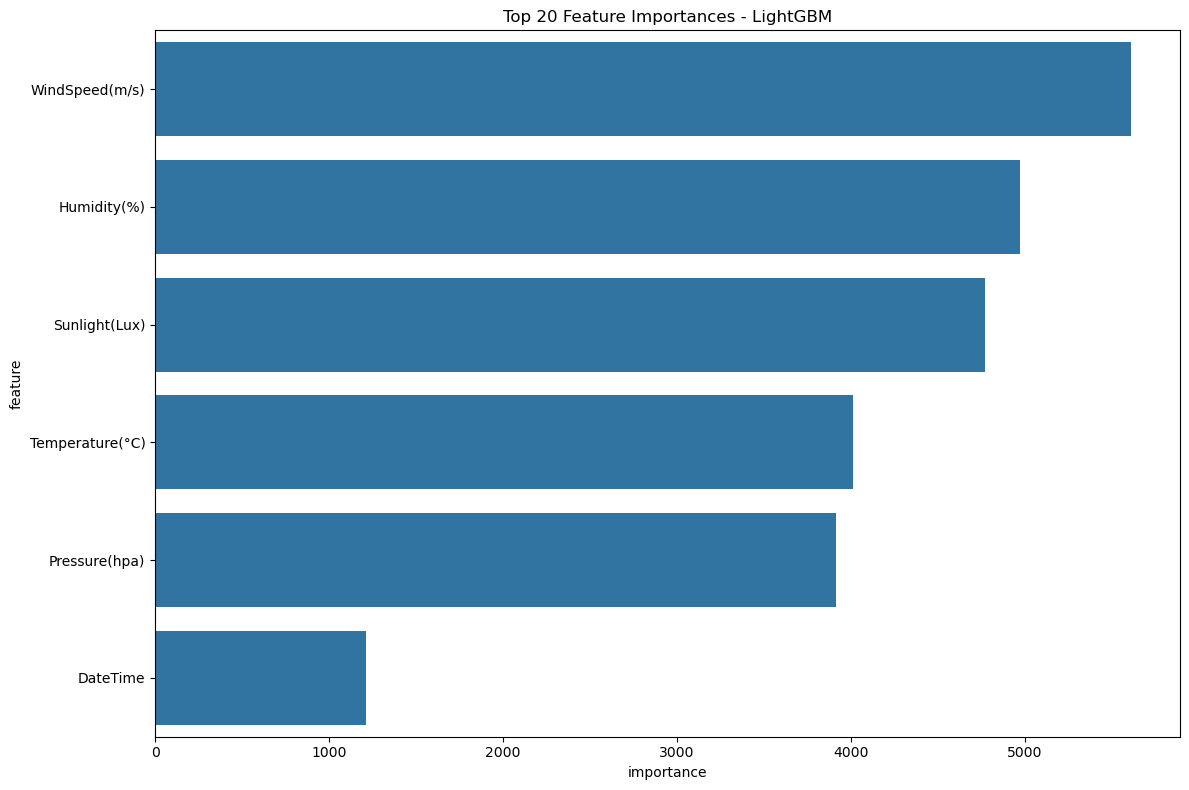


Performing Residual Analysis for LightGBM...


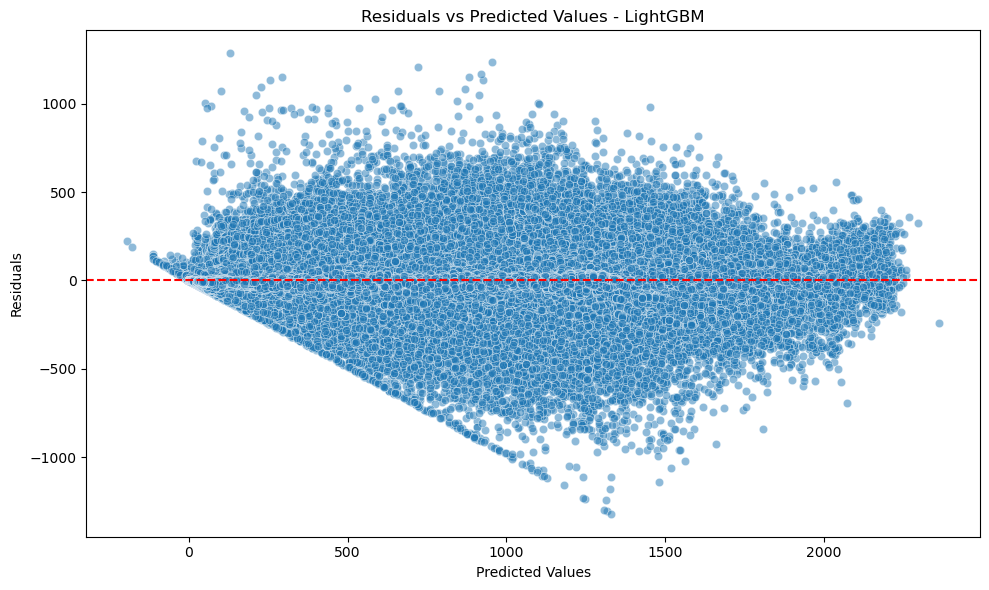

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from tqdm import tqdm
import optuna
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# Configuration and Constants
# ----------------------------

TRAIN_DATA_DIR = './TrainingData'  # Replace with your training data directory path
SUBMISSION_PATH = './submission.csv'  # Replace with your desired submission path

TARGET_COLUMN = 'Power(mW)'  # Replace with your target column name
ID_COLUMN = 'LocationCode'    # Replace with your ID column name (if available)
N_SPLITS = 5                   # Number of folds for cross-validation
RANDOM_STATE = 42

# ----------------------------
# Function Definitions
# ----------------------------

def load_training_data(train_dir):
    all_files = [os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.endswith('.csv')]
    if not all_files:
        raise ValueError(f"No CSV files found in the directory: {train_dir}")
    
    df_list = []
    for file in all_files:
        df = pd.read_csv(file)
        df_list.append(df)
    
    combined_df = pd.concat(df_list, ignore_index=True)
    print(f"Loaded {len(all_files)} files with total {combined_df.shape[0]} rows.")
    return combined_df

def optimize_data_types(df):
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

def preprocess_data(df, target, id_col=None):
    if id_col and id_col in df.columns:
        df = df.drop(columns=[id_col])
    
    df = optimize_data_types(df)
    
    X = df.drop(columns=[target])
    y = df[target]
    
    # Identify numerical and categorical columns
    numerical_cols = X.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    
    print(f"Numerical columns: {numerical_cols}")
    print(f"Categorical columns: {categorical_cols}")
    
    # Convert object types to category
    for col in categorical_cols:
        X[col] = X[col].astype('category')
    
    # Encoding: Target Encoding
    target_encoder = ce.TargetEncoder(cols=categorical_cols)
    X[categorical_cols] = target_encoder.fit_transform(X[categorical_cols], y)
    
    # Feature Selection: Remove low variance features
    from sklearn.feature_selection import VarianceThreshold
    selector = VarianceThreshold(threshold=0.01)
    
    # Store original column names before transformation
    original_columns = X.columns.tolist()
    
    # Apply feature selection
    X_transformed = selector.fit_transform(X)
    
    # Get selected feature indices
    selected_indices = selector.get_support(indices=True)
    
    # Retrieve selected feature names
    selected_feature_names = [original_columns[i] for i in selected_indices]
    
    # Convert back to DataFrame with selected feature names
    X_selected = pd.DataFrame(X_transformed, columns=selected_feature_names)
    
    # Update numerical_cols to include only selected numerical features
    selected_numerical_cols = [col for col in numerical_cols if col in selected_feature_names]
    
    # Include target-encoded categorical features in numerical_cols
    # Assuming target encoding replaces categorical columns with numerical ones
    # If target-encoded columns have different names, adjust accordingly
    # For simplicity, assuming the same names
    selected_categorical_cols = [col for col in categorical_cols if col in selected_feature_names]
    selected_numerical_cols += selected_categorical_cols
    
    # Preprocessing Pipeline
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])
    
    # Since categorical variables are already target encoded, no need for further encoding
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, selected_numerical_cols)
            # No categorical transformer needed
        ],
        remainder='passthrough'  # Pass through any remaining features
    )
    
    return X_selected, y, preprocessor

def evaluate_model(model, X, y, preprocessor, n_splits=5, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    total_error = 0
    fold = 1
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Create a pipeline with preprocessing and the model
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Fit the model
        pipeline.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = pipeline.predict(X_val)
        
        # Calculate absolute errors
        abs_errors = np.abs(y_pred - y_val)
        
        # Sum the absolute errors as per competition scoring
        fold_error = abs_errors.sum()
        total_error += fold_error
        
        print(f"Fold {fold}: Error = {fold_error:.2f}")
        fold += 1
    
    return total_error

def get_best_models():
    # Placeholder for best models after hyperparameter tuning
    # Replace these with the best params obtained from hyperparameter tuning
    best_lightgbm = LGBMRegressor(
        num_leaves=50,
        max_depth=10,
        learning_rate=0.05,
        n_estimators=500,
        min_child_samples=30,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    best_xgb = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=10,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    best_catb = CatBoostRegressor(
        iterations=500,
        learning_rate=0.05,
        depth=10,
        l2_leaf_reg=3,
        bagging_temperature=0.2,
        random_state=RANDOM_STATE,
        verbose=0
    )
    
    return best_lightgbm, best_xgb, best_catb

def main():
    # Load the training data
    print("Loading training data...")
    df = load_training_data(TRAIN_DATA_DIR)
    
    # Preprocess the data
    print("\nPreprocessing data...")
    X, y, preprocessor = preprocess_data(df, target=TARGET_COLUMN, id_col=ID_COLUMN)
    
    # Get the best models
    best_lightgbm, best_xgb, best_catb = get_best_models()
    
    # Evaluate individual models
    print("\nEvaluating individual models...")
    models = {
        'LightGBM': best_lightgbm,
        'XGBoost': best_xgb,
        'CatBoost': best_catb
    }
    
    results = {}
    for model_name, model in tqdm(models.items(), desc="Models"):
        print(f"\nEvaluating {model_name}...")
        total_error = evaluate_model(model, X, y, preprocessor, n_splits=N_SPLITS, random_state=RANDOM_STATE)
        results[model_name] = total_error
        print(f"Total Absolute Error for {model_name}: {total_error:.2f}")
    
    # Ensemble Models
    print("\nCreating and evaluating ensemble models...")
    
    # Voting Regressor
    voting_reg = VotingRegressor(estimators=[
        ('lightgbm', best_lightgbm),
        ('xgb', best_xgb),
        ('catb', best_catb)
    ], n_jobs=-1)
    
    print("\nEvaluating Voting Regressor...")
    total_error_voting = evaluate_model(voting_reg, X, y, preprocessor, n_splits=N_SPLITS, random_state=RANDOM_STATE)
    results['Voting Regressor'] = total_error_voting
    print(f"Total Absolute Error for Voting Regressor: {total_error_voting:.2f}")
    
    # Stacking Regressor
    stacking_reg = StackingRegressor(
        estimators=[
            ('lightgbm', best_lightgbm),
            ('xgb', best_xgb),
            ('catb', best_catb)
        ],
        final_estimator=LinearRegression(),
        n_jobs=-1
    )
    
    print("\nEvaluating Stacking Regressor...")
    total_error_stacking = evaluate_model(stacking_reg, X, y, preprocessor, n_splits=N_SPLITS, random_state=RANDOM_STATE)
    results['Stacking Regressor'] = total_error_stacking
    print(f"Total Absolute Error for Stacking Regressor: {total_error_stacking:.2f}")
    
    # Sort results by total error
    sorted_results = sorted(results.items(), key=lambda x: x[1])
    
    # Display the comparison
    print("\nModel Performance Comparison:")
    print("{:<25}{}".format("Model", "Total Absolute Error"))
    print("-" * 40)
    for model_name, error in sorted_results:
        print("{:<25}{:.2f}".format(model_name, error))
    
    # Save the results to a CSV file
    results_df = pd.DataFrame(sorted_results, columns=['Model', 'Total_Absolute_Error'])
    results_df.to_csv('model_comparison_results_optimized.csv', index=False)
    print("\nResults saved to 'model_comparison_results_optimized.csv'.")
    
    # Plot Feature Importances for LightGBM
    print("\nPlotting Feature Importances for LightGBM...")
    pipeline_lightgbm = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', best_lightgbm)
    ])
    pipeline_lightgbm.fit(X, y)
    
    importances = pipeline_lightgbm.named_steps['model'].feature_importances_
    feature_names = X.columns.tolist()
    
    feature_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
    plt.title('Top 20 Feature Importances - LightGBM')
    plt.tight_layout()
    plt.show()
    
    # Residual Analysis for LightGBM
    print("\nPerforming Residual Analysis for LightGBM...")
    y_pred = pipeline_lightgbm.predict(X)
    residuals = y - y_pred
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted Values - LightGBM')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

In [8]:
import os
import pandas as pd
import numpy as np
import glob
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Define file paths (Update these paths accordingly)
TRAIN_DATA_DIR = './TrainingData'  # Replace with your training data directory path
TEST_DATA_PATH = './TestData/test.csv'  # Replace with your test data path
SUBMISSION_PATH = './submission.csv'   # Replace with your desired submission path

# Define constants
TARGET_COLUMN = 'Power(mW)'          # Replace with your target column name
ID_COLUMN = 'LocationCode'            # Replace with your ID column name (if available)
DATETIME_COLUMN = 'DateTime'          # Replace with your datetime column name
N_SPLITS = 5                          # Number of folds for cross-validation
RANDOM_STATE = 42
SEQUENCE_LENGTH = 24                  # Number of past hours to consider for prediction

# Function to load and concatenate all training CSV files
def load_training_data(train_dir):
    all_files = glob.glob(os.path.join(train_dir, "*.csv"))
    df_list = []
    for file in all_files:
        df = pd.read_csv(file)
        df_list.append(df)
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

# Function to preprocess data
def preprocess_data(df, scaler=None, encoder=None, fit_scaler=True, fit_encoder=True):
    # Parse DateTime
    df[DATETIME_COLUMN] = pd.to_datetime(df[DATETIME_COLUMN])
    df = df.sort_values(by=[ID_COLUMN, DATETIME_COLUMN])
    
    # Extract datetime features
    df['hour'] = df[DATETIME_COLUMN].dt.hour
    df['day'] = df[DATETIME_COLUMN].dt.day
    df['month'] = df[DATETIME_COLUMN].dt.month
    df['weekday'] = df[DATETIME_COLUMN].dt.weekday
    
    # Drop original DateTime
    df = df.drop(columns=[DATETIME_COLUMN])
    
    # Handle categorical variables (LocationCode) with OneHotEncoder
    if encoder is None and fit_encoder:
        # Updated parameter name for scikit-learn >=1.2
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded = encoder.fit_transform(df[[ID_COLUMN]])
    else:
        encoded = encoder.transform(df[[ID_COLUMN]])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([ID_COLUMN]))
    df = pd.concat([df.drop(columns=[ID_COLUMN]), encoded_df], axis=1)
    
    # Separate target
    if TARGET_COLUMN in df.columns:
        y = df[TARGET_COLUMN].values
        df = df.drop(columns=[TARGET_COLUMN])
    else:
        y = None
    
    # Feature scaling
    feature_cols = df.columns
    if scaler is None and fit_scaler:
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(df)
    else:
        scaled = scaler.transform(df)
    scaled_df = pd.DataFrame(scaled, columns=feature_cols)
    
    if y is not None:
        return scaled_df, y, scaler, encoder
    else:
        return scaled_df, scaler, encoder

# Function to create sequences for LSTM
def create_sequences(data, target, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length].values)
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

# Load and preprocess training data
print("Loading training data...")
train_df = load_training_data(TRAIN_DATA_DIR)
print(f"Training data shape: {train_df.shape}")

print("Preprocessing training data...")
processed_train, y, scaler, encoder = preprocess_data(train_df)
print(f"Processed training data shape: {processed_train.shape}")

# Create sequences
print("Creating sequences for LSTM...")
X, y = create_sequences(processed_train, y, SEQUENCE_LENGTH)
print(f"Input shape: {X.shape}, Target shape: {y.shape}")

# Define K-Fold Cross-Validation
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
fold = 1
mae_scores = []

for train_index, val_index in kf.split(X):
    print(f"Training fold {fold}...")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Define LSTM model
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mae')
    
    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        verbose=1
    )
    
    # Evaluate the model
    val_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, val_pred)
    print(f"Fold {fold} MAE: {mae}")
    mae_scores.append(mae)
    fold += 1

print(f"Average MAE across folds: {np.mean(mae_scores)}")

# Train final model on all data
print("Training final model on all data...")
final_model = Sequential()
final_model.add(LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
final_model.add(Dropout(0.2))
final_model.add(LSTM(32))
final_model.add(Dropout(0.2))
final_model.add(Dense(1))

final_model.compile(optimizer='adam', loss='mae')

early_stop_final = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

final_model.fit(
    X, y,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_final],
    verbose=1
)

# Load and preprocess test data
print("Loading test data...")
test_df = pd.read_csv(TEST_DATA_PATH)
print(f"Test data shape: {test_df.shape}")

print("Preprocessing test data...")
processed_test, scaler, encoder = preprocess_data(test_df, scaler=scaler, encoder=encoder, fit_scaler=False, fit_encoder=False)

# Since LSTM requires sequences, we need to create sequences from test data
print("Creating sequences for test data...")
# Combine the last SEQUENCE_LENGTH records from training data with test data for each location
test_sequences = []
test_ids = []
for loc in test_df[ID_COLUMN].unique():
    # Extract training data for the location
    loc_train = processed_train[train_df[ID_COLUMN] == loc]
    
    # Extract test data for the location
    loc_test = test_df[test_df[ID_COLUMN] == loc].copy()
    loc_test_processed, _, _ = preprocess_data(loc_test, scaler=scaler, encoder=encoder, fit_scaler=False, fit_encoder=False)
    
    # Combine last SEQUENCE_LENGTH records from training with test data
    combined_loc = pd.concat([loc_train.tail(SEQUENCE_LENGTH), loc_test_processed], ignore_index=True)
    
    # Create sequences
    for i in range(len(loc_test)):
        seq = combined_loc.iloc[i:i+SEQUENCE_LENGTH].values
        test_sequences.append(seq)
        test_ids.append(loc)
        
# Convert to numpy array
X_test = np.array(test_sequences)
print(f"Test input shape: {X_test.shape}")

# Predict on test data
print("Making predictions on test data...")
test_predictions = final_model.predict(X_test).flatten()

# Prepare submission
print("Preparing submission file...")
submission = test_df.copy()
submission[TARGET_COLUMN] = test_predictions
submission = submission[[ID_COLUMN, DATETIME_COLUMN, TARGET_COLUMN]]  # Adjust columns as per competition requirements

# Save submission
print(f"Saving submission to {SUBMISSION_PATH}...")
submission.to_csv(SUBMISSION_PATH, index=False, encoding='utf-8')

print("Submission file created successfully!")

Loading training data...
Training data shape: (1375028, 8)
Preprocessing training data...
Processed training data shape: (1375028, 26)
Creating sequences for LSTM...
Input shape: (1375004, 24, 26), Target shape: (1375004,)
Training fold 1...
Epoch 1/100
17188/17188 ━━━━━━━━━━━━━━━━━━━━ 287s 16ms/step - loss: 208.5207 - val_loss: 134.2924
Epoch 2/100
17188/17188 ━━━━━━━━━━━━━━━━━━━━ 256s 15ms/step - loss: 121.4375 - val_loss: 81.6553
Epoch 3/100
17188/17188 ━━━━━━━━━━━━━━━━━━━━ 347s 20ms/step - loss: 76.9947 - val_loss: 54.6498
Epoch 4/100
17188/17188 ━━━━━━━━━━━━━━━━━━━━ 230s 13ms/step - loss: 57.1201 - val_loss: 46.0783
Epoch 5/100
17188/17188 ━━━━━━━━━━━━━━━━━━━━ 328s 19ms/step - loss: 52.3955 - val_loss: 44.4318
Epoch 6/100
17188/17188 ━━━━━━━━━━━━━━━━━━━━ 210s 12ms/step - loss: 50.7614 - val_loss: 43.3024
Epoch 7/100
17188/17188 ━━━━━━━━━━━━━━━━━━━━ 208s 12ms/step - loss: 50.0967 - val_loss: 42.5722
Epoch 8/100
17188/17188 ━━━━━━━━━━━━━━━━━━━━ 208s 12ms/step - loss: 49.3404 - val_l

FileNotFoundError: [Errno 2] No such file or directory: './TestData/test.csv'